In [1]:
%load_ext autoreload
%autoreload 2

### Building a cooccurrence matrix to deal with textual data using Reuters corpus

In [2]:
# import nltk
# nltk.download('brown')
from sinr.text.cooccurrence import Cooccurrence
from sinr.text.pmi import pmi_filter
from nltk.corpus import brown
from nltk.corpus import reuters
c = Cooccurrence()
c.fit(reuters.sents(), window=100)
c.matrix = pmi_filter(c.matrix)
c.save("matrix.pk")

/home/dugue/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/dugue/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/dugue/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/dugue/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### Creating a SINr object from the cooccurrence matrix pickle, and detecting communities on the graph extracted from this matrix

In [3]:
import sinr.graph_embeddings as ge
sinr = ge.SINr.load_from_cooc_pkl("matrix.pk")
communities = sinr.detect_communities(gamma=300)

2023-01-18 17:14:30,408 - load_from_cooc_pkl - INFO - Building Graph.
2023-01-18 17:14:30,409 - load_pkl_text - INFO - Loading cooccurrence matrix and dictionary.
2023-01-18 17:14:30,423 - load_pkl_text - INFO - Finished loading data.
2023-01-18 17:14:31,780 - load_from_cooc_pkl - INFO - Finished building graph.
2023-01-18 17:14:31,784 - detect_communities - INFO - Detecting communities.
/home/dugue/miniconda3/envs/py39/lib/python3.9/site-packages/networkit/stopwatch.py:49: UserWarning: networkit.Timer is deprecated, will be removed in future updates.
  warn("networkit.Timer is deprecated, will be removed in future updates.")
2023-01-18 17:14:32,405 - detect_communities - INFO - Finished detecting communities.


Communities detected in 0.54858 [s]
solution properties:
-------------------  --------------
# communities        9095
min community size      1
max community size     39
avg. community size     4.57383
imbalance               7.8
edge cut                2.50215e+07
edge cut (portion)      7.02285
modularity              0.00945736
-------------------  --------------


### Extracting the embeddings using the SINr approach

In [4]:
sinr.extract_embeddings(communities)

2023-01-18 17:14:32,424 - extract_embeddings - INFO - Extracting embeddings.
2023-01-18 17:14:32,425 - extract_embeddings - INFO - Applying NFM.
2023-01-18 17:14:32,426 - get_nfm_embeddings - INFO - Starting NFM
/home/dugue/Depotgit/sinr/sinr/nfm.py:37: RuntimeWarning: divide by zero encountered in reciprocal
  weighted_membership = membership_matrix.multiply(np.reciprocal(community_weights).astype('float')) # 1/community_weight for each column of the membership matrix
2023-01-18 17:14:44,278 - extract_embeddings - INFO - NFM successfully applied.
2023-01-18 17:14:44,279 - extract_embeddings - INFO - Finished extracting embeddings.


### Using the ModelBuilder to get SINrVectors, a model that one can play with. Here we decide to use the node recall embedding. No additional information kept in the model.

In [5]:
sinr_vectors = ge.ModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=5).with_embeddings_nr().build()

In [6]:
sinr_vectors.most_similar(1)

{'object ': 1,
 'neighbors ': [(26133, 0.68), (41261, 0.68), (40033, 0.66), (27788, 0.66)]}

### Here, the ModelBuilder is used to keep the interpretability of the approach (using with_communities) and it allows also to use the words instead of integers (with_vocabulary)

In [7]:
sinr_vectors = ge.ModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=15).with_embeddings_nr().with_vocabulary().with_communities().build()

In [8]:
sinr_vectors.most_similar("trading")

{'object ': 'trading',
 'neighbors ': [('closed', 0.59),
  ('traded', 0.57),
  ('Friday', 0.56),
  ('Tuesday', 0.53),
  ('put', 0.51),
  ('Stock', 0.48),
  ('Monday', 0.48),
  ('futures', 0.47),
  ('meeting', 0.46),
  ('aimed', 0.45),
  ('Thursday', 0.45),
  ('firmer', 0.44),
  ('pushed', 0.42),
  ('1100', 0.42)]}

### An InterpretableWordsModelBuilder could also be used for shorter code : no "with" to use, those are done by default

In [9]:
sinr_vectors = ge.InterpretableWordsModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=15).build()

In [10]:
sinr_vectors.most_similar("trading")

{'object ': 'trading',
 'neighbors ': [('closed', 0.59),
  ('traded', 0.57),
  ('Friday', 0.56),
  ('Tuesday', 0.53),
  ('put', 0.51),
  ('Stock', 0.48),
  ('Monday', 0.48),
  ('futures', 0.47),
  ('meeting', 0.46),
  ('aimed', 0.45),
  ('Thursday', 0.45),
  ('firmer', 0.44),
  ('pushed', 0.42),
  ('1100', 0.42)]}

### What is the community which "liberal" belongs to ?

In [11]:
sinr_vectors.get_dimension_descriptors("liberal")

{'dimension': 4407, 'descriptors': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat'), (0.08, 'legislators'), (0.08, 'Republicans'), (0.07, 'liberal'), (0.05, 'Democrats'), (0.05, 'winning'), (0.04, 'minute'), (0.03, 'conservative')]}

In [12]:
sinr_vectors.get_dimension_descriptors("liberal", topk=5)

{'dimension': 4407, 'descriptors': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat'), (0.08, 'legislators'), (0.08, 'Republicans')]}

### What are the dimensions useful to describe "liberal" and what are the words that belong to the corresponding communities ?

In [13]:
sinr_vectors.get_obj_descriptors("liberal", topk_dim=3,topk_val=5)

[{'dimension': 4407,
  'value': 0.06927710843373494,
  'descriptors': [(0.12, 'revolt'),
   (0.1, 'alliance'),
   (0.09, 'defeat'),
   (0.08, 'legislators'),
   (0.08, 'Republicans')]},
 {'dimension': 7244,
  'value': 0.045180722891566265,
  'descriptors': [(0.0, 'a')]},
 {'dimension': 8427,
  'value': 0.04216867469879518,
  'descriptors': [(0.0, 'in')]}]

### What are the words that have high values on the dimension corresponding to the community wine belongs to ?

In [14]:
sinr_vectors.get_dimension_stereotypes("wine", topk=10)

{'dimension': 3427, 'stereotypes': [(0.29, 'MCGINNESS'), (0.25, 'HEUBLEIN'), (0.25, 'brandy'), (0.25, 'Calona'), (0.25, 'liquers'), (0.25, 'Wines'), (0.25, 'liquors'), (0.21, 'McGuinness'), (0.2, 'CORBY'), (0.2, 'DISTILLERIES')]}

It can be compared to the words that constitute the community

In [15]:
sinr_vectors.get_dimension_descriptors("wine", topk=10)

{'dimension': 3427, 'descriptors': [(0.29, 'MCGINNESS'), (0.25, 'brandy'), (0.25, 'HEUBLEIN'), (0.25, 'Calona'), (0.25, 'liquers'), (0.25, 'liquors'), (0.25, 'Wines'), (0.21, 'McGuinness'), (0.2, 'DISTILLERIES'), (0.2, 'CORBY')]}

### What are the 3 words that have high values on the 5 dimensions that are useful to describe "liberal" ?

In [16]:
sinr_vectors.get_obj_stereotypes("liberal", topk_dim=5, topk_val=3)

[{'dimension': 4407,
  'value': 0.06927710843373494,
  'stereotypes': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat')]},
 {'dimension': 7244,
  'value': 0.045180722891566265,
  'stereotypes': [(0.19, 'Studebaker'),
   (0.19, 'Dealerships'),
   (0.19, 'Chevy')]},
 {'dimension': 8427,
  'value': 0.04216867469879518,
  'stereotypes': [(0.25, 'parentheses'), (0.2, 'Pesos'), (0.18, 'exile')]},
 {'dimension': 431,
  'value': 0.018072289156626505,
  'stereotypes': [(0.16, 'Kippur'), (0.16, 'Yom'), (0.1, 'pullout')]},
 {'dimension': 8998,
  'value': 0.018072289156626505,
  'stereotypes': [(0.2, 'Rumours'),
   (0.12, 'acknowledging'),
   (0.11, 'responsibly')]}]

It can be compared with the words that constitute the communities representing these dimensions

In [17]:
sinr_vectors.get_obj_stereotypes_and_descriptors("liberal", topk_dim=5, topk_val=3)

[{'dimension': 4407,
  'value': 0.06927710843373494,
  'stereotypes': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat')],
  'descriptors': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat')]},
 {'dimension': 7244,
  'value': 0.045180722891566265,
  'stereotypes': [(0.19, 'Studebaker'),
   (0.19, 'Dealerships'),
   (0.19, 'Chevy')],
  'descriptors': [(0.0, 'a')]},
 {'dimension': 8427,
  'value': 0.04216867469879518,
  'stereotypes': [(0.25, 'parentheses'), (0.2, 'Pesos'), (0.18, 'exile')],
  'descriptors': [(0.0, 'in')]},
 {'dimension': 431,
  'value': 0.018072289156626505,
  'stereotypes': [(0.16, 'Kippur'), (0.16, 'Yom'), (0.1, 'pullout')],
  'descriptors': [(0.16, 'Yom'), (0.16, 'Kippur'), (0.1, 'pullout')]},
 {'dimension': 8998,
  'value': 0.018072289156626505,
  'stereotypes': [(0.2, 'Rumours'),
   (0.12, 'acknowledging'),
   (0.11, 'responsibly')],
  'descriptors': [(0.0, 'that')]}]

### Saving and loading SINrVectors objects

In [18]:
sinr_vectors.save()

In [19]:
# The name should be the same, it is used to load the pickle
sinr_vectors_new = ge.SINrVectors("reuters")
sinr_vectors_new.load()

In [20]:
sinr_vectors_new.get_obj_stereotypes_and_descriptors("liberal", topk_dim=5, topk_val=3)

[{'dimension': 4407,
  'value': 0.06927710843373494,
  'stereotypes': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat')],
  'descriptors': [(0.12, 'revolt'), (0.1, 'alliance'), (0.09, 'defeat')]},
 {'dimension': 7244,
  'value': 0.045180722891566265,
  'stereotypes': [(0.19, 'Studebaker'),
   (0.19, 'Dealerships'),
   (0.19, 'Chevy')],
  'descriptors': [(0.0, 'a')]},
 {'dimension': 8427,
  'value': 0.04216867469879518,
  'stereotypes': [(0.25, 'parentheses'), (0.2, 'Pesos'), (0.18, 'exile')],
  'descriptors': [(0.0, 'in')]},
 {'dimension': 431,
  'value': 0.018072289156626505,
  'stereotypes': [(0.16, 'Kippur'), (0.16, 'Yom'), (0.1, 'pullout')],
  'descriptors': [(0.16, 'Yom'), (0.16, 'Kippur'), (0.1, 'pullout')]},
 {'dimension': 8998,
  'value': 0.018072289156626505,
  'stereotypes': [(0.2, 'Rumours'),
   (0.12, 'acknowledging'),
   (0.11, 'responsibly')],
  'descriptors': [(0.0, 'that')]}]

### Visualisation

In [21]:
import sinr.viz as viz

In [22]:
sinr_viz = viz.SINrViz(sinr_vectors)

{8998, 8427, 7244, 43, 431, 1973, 4407, 8508}


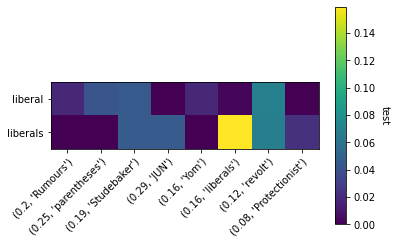

In [23]:
sinr_viz.compare_stereotypes(["liberal", "liberals"])

{7677, 3427, 8999, 10, 8862, 5101, 7409, 8370, 4125, 4382}


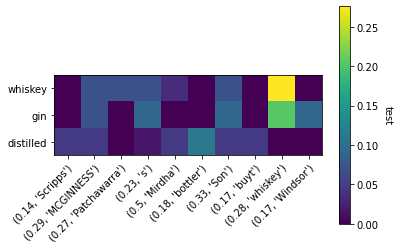

In [24]:
sinr_viz.compare_stereotypes(["whiskey", "gin", "distilled"])

### Thresholded

In [57]:
sinr_vectors = ge.ThresholdedModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=15).build(threshold=0)
print(sinr_vectors.pct_nnz())
print(sinr_vectors.get_nnv())

1.5460205339386501
2


In [58]:
sinr_vectors.most_similar("trading")

{'object ': 'trading',
 'neighbors ': [('closed', 0.59),
  ('traded', 0.57),
  ('Friday', 0.56),
  ('Tuesday', 0.53),
  ('put', 0.51),
  ('Stock', 0.48),
  ('Monday', 0.48),
  ('futures', 0.47),
  ('meeting', 0.46),
  ('aimed', 0.45),
  ('Thursday', 0.45),
  ('firmer', 0.44),
  ('pushed', 0.42),
  ('1100', 0.42)]}

In [59]:
sinr_vectors = ge.ThresholdedModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=15).build(threshold=0.01)
print(sinr_vectors.pct_nnz())
print(sinr_vectors.get_nnv())

0.3004441169578692
5


In [60]:
sinr_vectors.most_similar("trading")

{'object ': 'trading',
 'neighbors ': [('closed', 0.82),
  ('put', 0.82),
  ('meeting', 0.82),
  ('Friday', 0.79),
  ('Tuesday', 0.79),
  ('traded', 0.72),
  ('Saturday', 0.72),
  ('Monday', 0.72),
  ('reaching', 0.72),
  ('values', 0.69),
  ('Thursday', 0.67),
  ('1100', 0.65),
  ('firmer', 0.64),
  ('closing', 0.63)]}

In [61]:
sinr_vectors = ge.ThresholdedModelBuilder(sinr, "reuters", n_jobs=8, n_neighbors=15).build(threshold=0.02)
print(sinr_vectors.pct_nnz())
print(sinr_vectors.get_nnv())

0.15966283284736105
298


In [62]:
sinr_vectors.most_similar("trading")

{'object ': 'trading',
 'neighbors ': [('put', 0.99),
  ('meeting', 0.99),
  ('closed', 0.99),
  ('closing', 0.99),
  ('Friday', 0.93),
  ('1100', 0.86),
  ('traded', 0.85),
  ('puts', 0.84),
  ('firmer', 0.83),
  ('nickel', 0.74),
  ('insufficient', 0.73),
  ('movements', 0.73),
  ('differences', 0.73),
  ('pact', 0.73)]}